# OWG Policy in Pybullet

In [1]:
cd ..

c:\Users\86131\Downloads\OWG-main\OWG-main


c:\Users\86131\owg-env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Setup Pybullet Env

In [3]:
from owg_robot.env import *
from owg_robot.camera import Camera
from owg_robot.objects import YcbObjects

In [4]:
#p.disconnect()

# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (448, 448), 40)
env = Environment(camera, vis=True, asset_root='./owg_robot/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./owg_robot/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=42
)
objects.shuffle_objects()

n_objects = 12

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

In [5]:
import sys
import os

# 添加 inference 的上一级目录（使得 inference 可以被当作包导入）
project_root = os.path.abspath("third_party/grconvnet")
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [6]:
from third_party.grconvnet import *
from owg.utils.grasp import Grasp2D

grasp_generator = load_grasp_generator(camera)

INFO:root:CUDA detected. Running with GPU acceleration.


224 224


<Figure size 1000x1000 with 0 Axes>

In [7]:
def setup_grasps(env, grasp_generator, visualise_grasps=False):
        rgb, depth, seg = env.camera.get_cam_img()    
        img_size = grasp_generator.IMG_WIDTH
        if  img_size != camera.width: 
            rgb = cv2.resize(rgb, (img_size, img_size))
            depth = cv2.resize(depth, (img_size, img_size))
        for obj_id in env.obj_ids:
            mask = seg == obj_id
            if img_size != camera.width:
                mask = np.array(Image.fromarray(mask).resize((img_size, img_size), Image.LANCZOS))
            grasps, grasp_rects = grasp_generator.predict_grasp_from_mask(rgb,
                                                           depth,
                                                           mask,
                                                           n_grasps=5, 
                                                           show_output=True
            )
            if img_size != camera.width:
                # normalize to original size
                for j, gr in enumerate(grasp_rects):
                    grasp_rects[j][0] = int(gr[0] / img_size * camera.width)
                    grasp_rects[j][1] = int(gr[1] / img_size * camera.width)
                    grasp_rects[j][4] = int(gr[4] / img_size * camera.width)
                    grasp_rects[j][3] = int(gr[3] / img_size * camera.width)
            grasp_rects = [Grasp2D.from_vector(
                x=g[1], y=g[0], w=g[4], h=g[3], theta=g[2], W=camera.width, H=camera.width, normalized=False, line_offset=5,
            ) for g in grasp_rects]
            env.set_obj_grasps(obj_id, grasps, grasp_rects)
        
        if visualise_grasps:
            LID =[]
            for obj_id in env.obj_ids:
                grasps = env.get_obj_grasps(obj_id)
                color = np.random.rand(3).tolist()
                for g in grasps:
                    LID = env.draw_predicted_grasp(g,color=color,lineIDs=LID)
            
            time.sleep(1)
            env.remove_drawing(LID)
            env.dummy_simulation_steps(10)

In [8]:
# run and visualize grasps -- check in your Pybullet client
setup_grasps(env, grasp_generator, visualise_grasps=True)

<Figure size 640x480 with 0 Axes>

In [9]:
obs = env.get_obs()

all_grasp_rects = {k: env.get_obj_grasp_rects(k) for k in env.obj_ids }

## Referring Segmentation

In [10]:
import os
os.environ["OPENROUTER_API_KEY"] = "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"


In [11]:
from owg.visual_prompt import VisualPrompterGrounding, VisualPrompterPlanning, VisualPrompterGraspRanking

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
config_path = 'config/pyb/OWG.yaml'

In [13]:
grounder = VisualPrompterGrounding(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [14]:
image, seg = obs['image'], obs['seg']
obj_ids = np.unique(seg)[1:]
all_masks = np.stack([seg == objID for objID in obj_ids])
marker_data = {'masks': all_masks, 'labels': obj_ids}

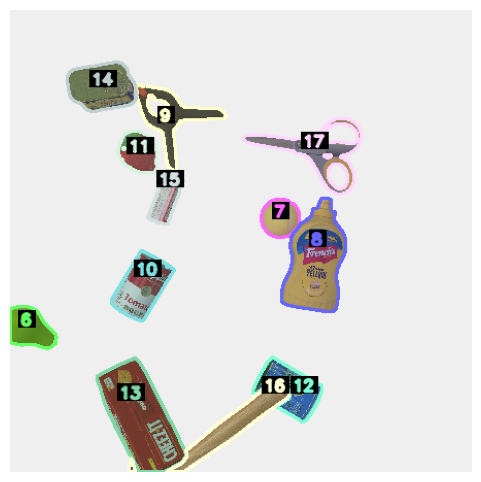

In [15]:
# show visual prompt
visual_promppt, _ = grounder.prepare_image_prompt(image.copy(), marker_data)
marked_image_grounding = visual_promppt[-1]
display_image(marked_image_grounding, (6,6))

In [16]:
print("API Key is:", os.environ.get("OPENROUTER_API_KEY"))


API Key is: 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


In [17]:
print(type(grounder))


<class 'owg.visual_prompt.VisualPrompterGrounding'>


In [18]:
# GPT request
user_query = "I want to cut some paper"

dets, target_mask, target_ids = grounder.request(text_query=user_query,image=image.copy(),data=marker_data)

GPT response:
To cut paper, you would need scissors. In the raw image, the scissors are located towards the top right. In the marked image, the scissors are labeled with ID 17.

My final answer is: [17]



17


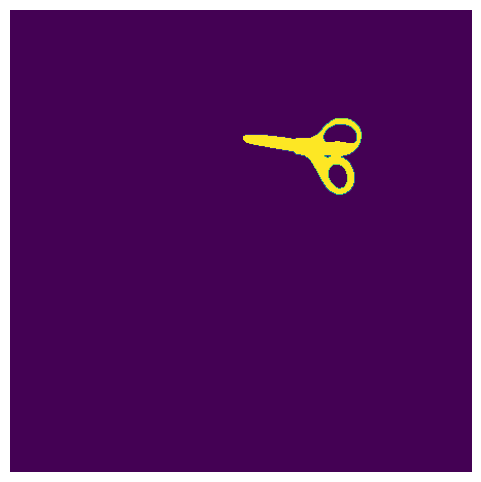

In [19]:
target_id = target_ids[0] # assume single correct object
print(target_id)
display_image(target_mask, (6,6))

## Grasp Planning

In [21]:
planner = VisualPrompterPlanning(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [22]:
plan = planner.request(text_query=target_id, image=image.copy(), data=marker_data)
if plan is None:
    print("⚠️ GPT did not return a valid plan.")
else:
    print("✅ Final plan:", plan)
    action = plan[0]


GPT response:
Plan:
```json
[
 {'action': 'pick', 'input': 17}
]
```

✅ Final plan: [{'action': 'pick', 'input': 17}]


In [23]:
plan = planner.request(text_query=target_id,
                                    image=image.copy(),
                                    data=marker_data)
action = plan[0]

GPT response:
Plan:
```json
[
 {'action': 'pick', 'input': 17}
]
```



In [24]:
action

{'action': 'pick', 'input': 17}

## Grasp Ranking

In [25]:
grasp_ranker = VisualPrompterGraspRanking(config_path, debug=True)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [26]:
obj_grasps = all_grasp_rects[action['input']]
obj_mask = all_masks[env.obj_ids.index(action['input'])]
req_data = {'grasps': obj_grasps, 'mask': obj_mask}

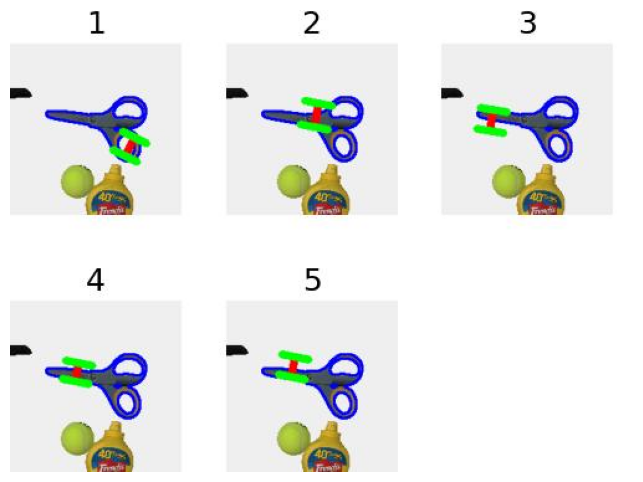

In [27]:
# show visual prompt
visual_prompt, _ = grasp_ranker.prepare_image_prompt(image.copy(), req_data)
marked_image_grasping = visual_prompt[-1]
display_image(marked_image_grasping, (12,6))

In [28]:
sorted_grasps, best_grasp, sorted_grasp_indices = grasp_ranker.request(image.copy(), req_data)

GPT response:
1) The object of interest is a pair of scissors. The surrounding objects are a ball and a bottle.

2) Grasp poses leading to contacts:
   - **Pose 1**: The fingers (green lines) would contact the bottle.
   - **Pose 2**: The fingers would contact the ball.
   - **Pose 3**: The fingers would contact the bottle.
   - **Pose 4**: The fingers would contact the ball.
   - **Pose 5**: The fingers would contact the ball.

3) Ranking of grasp poses from best to worst:
   - All poses lead to contact, so they are ranked based on proximity to the center of the scissors.
   - **Pose 3**: Closest to the center.
   - **Pose 1**: Second closest to the center.
   - **Pose 5**: Third closest to the center.
   - **Pose 2**: Fourth closest to the center.
   - **Pose 4**: Furthest from the center.

My final answer is: [3, 1, 5, 2, 4].



In [29]:
action['grasps'] = sorted_grasp_indices

In [30]:
        # take step
        if action['action'] == 'remove':
            success_grasp, success_target = env.put_obj_in_free_space(
                action['input'], grasp_indices=action['grasps'])
        elif action['action'] == 'pick':
            success_grasp, success_target = env.put_obj_in_tray(
                action['input'], grasp_indices=action['grasps'])
        for _ in range(30):
            env.step_simulation()
        print(success_grasp, success_target)

Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
Exceeded 3 grasping attempts.s
Grasping failed. Exitting
False False


In [52]:
!pip install pandas openpyxl


   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
    --------------------------------------- 0.3/11.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.3 MB 2.2 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/11.3 MB 1.6 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/11.3 MB 1.5 MB/s eta 0:00:07
   ----- ---------------------------------- 1.6/11.3 MB 1.6 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.3 MB 1.8 MB/s eta 0:00:05
   --------- ------------------------------ 2.6/11.3 MB 1.9 MB/s eta 0:00:05
   ----------- ---------------------------- 3.1/11.3 MB 1.9 MB/s eta 0:00:05
   ------------ --------------------------- 3.4/11.3 MB 1.9 MB/s eta 0:00:05
   ------------- -------------------------- 3.9/11.3 MB 1.8 MB/s eta 0:00:05
   -------------- ------------------------- 4.2/11.3 MB 1.9 MB/s eta 0:00:04
   ---------------- ----------------------- 4.7/11.3 MB 1.9 MB/s eta 0:00:04
   ----------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
p.disconnect()